**Причина выполнения лабораторной в Google Collaboratory**
Решено было выполнить данная лабортаорную в google collaboratory ввиду технических сложностей связанных с тем что библиотеки Python для CUDA рассчитаны на процессоры NVIDIA. Даже драйвер AMD Rocm не решает данной проблемы так как перестал он перестал поддерживается библиотеками для CUDA

In [ ]:
from numba import cuda, float32
import numba as nb
import numpy as np
import matplotlib.pyplot  as plt
from time import perf_counter as clock
import time
import math

**Перемножение матриц**
Задача: реализовать алгоритм перемножения матриц
Язык: C++ или Python
Входные данные: 2 матрицы размером от 100х100 до 2000х2000 каждая.
Выходные данные: проверка корректности перемножения + время вычисления
Реализация должна содержать 2 функции перемножения матриц: на CPU и на GPU с
применением CUDA.
Отчет о проделанной лабораторной работе - это git-репозиторий с исходным кодом
реализации + описание проделанной работы там же в readme.
Необходимо описать реализацию, объяснив, что конкретно было распараллелено и
почему.
Провести эксперименты: перемножить матрицы разных размеров, посчитать
ускорение. Результаты привести в виде таблицы/графика.

Реализуем алгоритм перемножения матриц на CPU

In [ ]:
matrix1 = np.arange(40000).reshape(200,200)
matrix2 = np.random.randint(40000, size=(200, 200))


In [ ]:
start = time.time()
matrix3 = np.matmul(matrix1, matrix1)
shape  = matrix3.shape
end = time.time() - start
print(f'Время выполнения операции на CPU: {end}\nРезультат выполнения умножения:{matrix3}\nРазмерности матрицы{shape}')

Время выполнения операции на CPU: 0.012836933135986328
Результат выполнения умножения:[[   529340000    529359900    529379800 ...    533260300    533280200
     533300100]
 [  1325340000   1325399900   1325459800 ...   1337140300   1337200200
    1337260100]
 [  2121340000   2121439900   2121539800 ...   2141020300   2141120200
    2141220100]
 ...
 [157341340000 157349239900 157357139800 ... 158897620300 158905520200
  158913420100]
 [158137340000 158145279900 158153219800 ... 159701500300 159709440200
  159717380100]
 [158933340000 158941319900 158949299800 ... 160505380300 160513360200
  160521340100]]
Размерности матрицы(200, 200)


Аналогичный алгоритм используя GPU, с помощью библиотеки numba

In [ ]:
@cuda.jit
def cuda_matmul(A, B, C):
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

In [ ]:
start_cuda = time.time()
temp_matrix = np.zeros((200,200))

mtr_cuda1 = cuda.to_device(matrix1)
mtr_cuda2 = cuda.to_device(matrix2)
mtr_cuda3 = cuda.to_device(temp_matrix)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(temp_matrix.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(temp_matrix.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

cuda_matmul[blockspergrid, threadsperblock](mtr_cuda1, mtr_cuda2, mtr_cuda3)
temp_matrix = mtr_cuda3.copy_to_host()
end_cuda = time.time() - start_cuda
shape_cuda = temp_matrix.shape
# print(temp_matrix)
# print(matrix1 @ matrix2)
print(f'Время выполнения операции на CPU: {end_cuda}\nРезультат выполнения умножения:{temp_matrix}\nРазмерности матрицы{shape_cuda}')

Время выполнения операции на CPU: 0.004723072052001953
Результат выполнения умножения:[[3.76563159e+08 4.26481217e+08 3.54593866e+08 ... 3.46297604e+08
  4.03340591e+08 4.05719266e+08]
 [1.12047736e+09 1.26403202e+09 1.11528967e+09 ... 1.05710400e+09
  1.21415239e+09 1.22730567e+09]
 [1.86439156e+09 2.10158282e+09 1.87598547e+09 ... 1.76791040e+09
  2.02496419e+09 2.04889207e+09]
 ...
 [1.46927661e+11 1.65423989e+11 1.50211666e+11 ... 1.40375158e+11
  1.60133265e+11 1.62258240e+11]
 [1.47671575e+11 1.66261540e+11 1.50972362e+11 ... 1.41085965e+11
  1.60944077e+11 1.63079826e+11]
 [1.48415489e+11 1.67099090e+11 1.51733058e+11 ... 1.41796771e+11
  1.61754889e+11 1.63901413e+11]]
Размерности матрицы(200, 200)


Далее приведен алгоритм оптимизировнного процесса переможения матриц (более быстрого), также использующий GPU
Источник: https://stackoverflow.com/questions/63727411/numba-cuda-shared-memory-matrix-multiplication

In [ ]:
# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
# TPB should not be larger than 32 in this example
TPB = 16

@cuda.jit
def opt_matmul(A, B, C):

    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = float32(0.)
    for i in range(bpg):
        # Preload data into shared memory
        sA[ty, tx] = 0
        sB[ty, tx] = 0
        if y < A.shape[0] and (tx + i * TPB) < A.shape[1]:
            sA[ty, tx] = A[y, tx + i * TPB]
        if x < B.shape[1] and (ty + i * TPB) < B.shape[0]:
            sB[ty, tx] = B[ty + i * TPB, x]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[ty, j] * sB[j, tx]

        # Wait until all threads finish computing
        cuda.syncthreads()
    if y < C.shape[0] and x < C.shape[1]:
        C[y, x] = tmp



In [ ]:
start_opt_cuda = time.time()
threadsperblock_opt = (TPB, TPB)
blockspergrid_x_opt = math.ceil(temp_matrix.shape[0] / threadsperblock_opt[0])
blockspergrid_y_opt = math.ceil(temp_matrix.shape[1] / threadsperblock_opt[1])
blockspergrid_opt = (blockspergrid_x_opt, blockspergrid_y_opt)

opt_matmul[blockspergrid, threadsperblock](mtr_cuda1, mtr_cuda2, mtr_cuda3)
temp_matrix = mtr_cuda3.copy_to_host()
end_opt_cuda = time.time() - start_opt_cuda
shape_opt_cuda = temp_matrix.shape
# print(temp_matrix)
# print(matrix1 @ matrix2)
print(f'Время выполнения операции на CPU: {end_opt_cuda}\nРезультат выполнения умножения:{temp_matrix}\nРазмерности матрицы{shape_opt_cuda}')

Время выполнения операции на CPU: 0.001697540283203125
Результат выполнения умножения:[[3.76563168e+08 4.26481120e+08 3.54593920e+08 ... 3.46297600e+08
  4.03340672e+08 4.05719200e+08]
 [1.12047718e+09 1.26403187e+09 1.11528973e+09 ... 1.05710381e+09
  1.21415258e+09 1.22730560e+09]
 [1.86439104e+09 2.10158285e+09 1.87598592e+09 ... 1.76791027e+09
  2.02496474e+09 2.04889178e+09]
 ...
 [1.46927682e+11 1.65423972e+11 1.50211674e+11 ... 1.40375146e+11
  1.60133267e+11 1.62258190e+11]
 [1.47671564e+11 1.66261539e+11 1.50972400e+11 ... 1.41085999e+11
  1.60944046e+11 1.63079766e+11]
 [1.48415513e+11 1.67099105e+11 1.51733027e+11 ... 1.41796786e+11
  1.61754857e+11 1.63901407e+11]]
Размерности матрицы(200, 200)


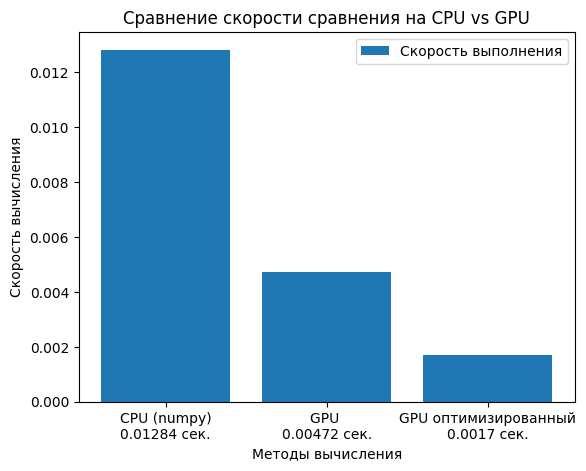

In [ ]:
x_label = [f'CPU (numpy)\n{round(end,5)} сек.', f'GPU \n{round(end_cuda, 5)} сек.', f'GPU оптимизированный\n{round(end_opt_cuda, 5)} сек.']
y_label = [end, end_cuda, end_opt_cuda]

plt.bar(x_label, y_label, label='Скорость выполнения')
plt.xlabel('Методы вычисления')
plt.ylabel('Скорость вычисления')
plt.title('Сравнение скорости сравнения на CPU vs GPU')
plt.legend()
plt.show()

In [ ]:
difference1 = end // end_cuda
difference2 = end_cuda // end_opt_cuda
difference3 = end // end_opt_cuda
print(f'Время выполнения на GPU в {difference1} быстрее чем на CPU\nВремя выполнения оптимизированного алгоритма GPU быстрее обычного алгоритма GPU в {difference2} раз\nВремя выпполнения оптимизированного алгоритма GPU быстрее CPU в раз {difference3}')

Время выполнения на GPU в 2.0 быстрее чем на CPU
Время выполнения оптимизированного алгоритма GPU быстрее обычного алгоритма GPU в 2.0 раз
Время выпполнения оптимизированного алгоритма GPU быстрее CPU в раз 7.0


2. Эксперимент по перемножению матриц разных размеров. И расчет ускорения

In [ ]:
new_matrix1 = np.arange(22500).reshape(150, 150)
new_matrix2 = np.random.randint(90000, size=(300, 300))

In [ ]:
start_exp = time.time()
new_matrix3 = np.matmul(new_matrix1, new_matrix1)
shape_exp  = new_matrix3.shape
end_exp = time.time() - start_exp
print(f'Время выполнения операции на CPU: {end_exp}\nРезультат выполнения умножения:{new_matrix3}\nРазмерности матрицы{shape_exp}')

Время выполнения операции на CPU: 0.013184309005737305
Результат выполнения умножения:[[  167066250   167077425   167088600 ...   168708975   168720150
    168731325]
 [  418503750   418537425   418571100 ...   423453975   423487650
    423521325]
 [  669941250   669997425   670053600 ...   678198975   678255150
    678311325]
 ...
 [37128378750 37131697425 37135016100 ... 37616223975 37619542650
  37622861325]
 [37379816250 37383157425 37386498600 ... 37870968975 37874310150
  37877651325]
 [37631253750 37634617425 37637981100 ... 38125713975 38129077650
  38132441325]]
Размерности матрицы(150, 150)


In [ ]:
start_cuda_exp = time.time()
new_temp_matrix = np.zeros((150,150))

mtr_cuda1_exp = cuda.to_device(new_matrix1)
mtr_cuda2_exp = cuda.to_device(new_matrix2)
mtr_cuda3_exp = cuda.to_device(new_temp_matrix)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(new_temp_matrix.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(new_temp_matrix.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

cuda_matmul[blockspergrid, threadsperblock](mtr_cuda1_exp, mtr_cuda2_exp, mtr_cuda3_exp)
new_temp_matrix = mtr_cuda3_exp.copy_to_host()
end_cuda_exp = time.time() - start_cuda_exp
shape_cuda_exp = new_temp_matrix.shape
# print(temp_matrix)
# print(matrix1 @ matrix2)
print(f'Время выполнения операции на CPU: {end_cuda_exp}\nРезультат выполнения умножения:{new_temp_matrix}\nРазмерности матрицы{shape_cuda_exp}')

Время выполнения операции на CPU: 0.004336833953857422
Результат выполнения умножения:[[5.00437775e+08 5.08837749e+08 4.79111402e+08 ... 5.32284140e+08
  4.67905545e+08 5.30292655e+08]
 [1.50786808e+09 1.50240610e+09 1.45930110e+09 ... 1.62066059e+09
  1.39936294e+09 1.59839766e+09]
 [2.51529838e+09 2.49597445e+09 2.43949080e+09 ... 2.70903704e+09
  2.33082034e+09 2.66650266e+09]
 ...
 [1.48592692e+11 1.46563385e+11 1.44566997e+11 ... 1.60523622e+11
  1.37392143e+11 1.57541728e+11]
 [1.49600122e+11 1.47556954e+11 1.45547187e+11 ... 1.61611999e+11
  1.38323601e+11 1.58609833e+11]
 [1.50607552e+11 1.48550522e+11 1.46527377e+11 ... 1.62700375e+11
  1.39255058e+11 1.59677938e+11]]
Размерности матрицы(150, 150)


In [ ]:
start_opt_cudaexp = time.time()
new_temp_matrix = np.zeros((150,150))
threadsperblock_opt = (TPB, TPB)
blockspergrid_x_opt = math.ceil(new_temp_matrix.shape[0] / threadsperblock_opt[0])
blockspergrid_y_opt = math.ceil(new_temp_matrix.shape[1] / threadsperblock_opt[1])
blockspergrid_opt = (blockspergrid_x_opt, blockspergrid_y_opt)

opt_matmul[blockspergrid, threadsperblock](mtr_cuda1_exp, mtr_cuda2_exp, mtr_cuda3_exp)
new_temp_matrix = mtr_cuda3_exp.copy_to_host()
end_opt_cudaexp = time.time() - start_opt_cudaexp
shape_opt_cudaexp = new_temp_matrix.shape
print(f'Время выполнения операции на CPU: {end_opt_cudaexp}\nРезультат выполнения умножения:{new_temp_matrix}\nРазмерности матрицы{shape_opt_cudaexp}')

Время выполнения операции на CPU: 0.0010297298431396484
Результат выполнения умножения:[[5.00437952e+08 5.08837664e+08 4.79111488e+08 ... 5.32284128e+08
  4.67905536e+08 5.30292672e+08]
 [1.50786829e+09 1.50240614e+09 1.45930086e+09 ... 1.62066074e+09
  1.39936282e+09 1.59839795e+09]
 [2.51529779e+09 2.49597440e+09 2.43949030e+09 ... 2.70903706e+09
  2.33081984e+09 2.66650189e+09]
 ...
 [1.48592689e+11 1.46563383e+11 1.44567009e+11 ... 1.60523633e+11
  1.37392103e+11 1.57541745e+11]
 [1.49600092e+11 1.47556925e+11 1.45547166e+11 ... 1.61612022e+11
  1.38323624e+11 1.58609834e+11]
 [1.50607561e+11 1.48550517e+11 1.46527388e+11 ... 1.62700329e+11
  1.39255054e+11 1.59677972e+11]]
Размерности матрицы(150, 150)


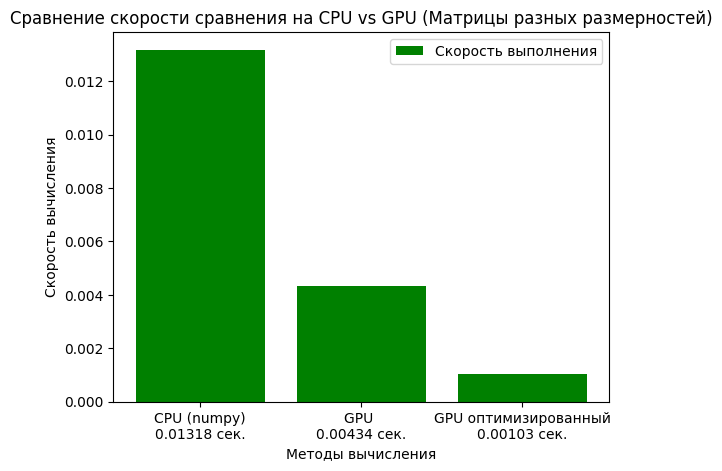

In [ ]:
x_label = [f'CPU (numpy)\n{round(end_exp,5)} сек.', f'GPU \n{round(end_cuda_exp, 5)} сек.', f'GPU оптимизированный\n{round(end_opt_cudaexp, 5)} сек.']
y_label = [end_exp, end_cuda_exp, end_opt_cudaexp]

plt.bar(x_label, y_label, label='Скорость выполнения', color='green')
plt.xlabel('Методы вычисления')
plt.ylabel('Скорость вычисления')
plt.title('Сравнение скорости сравнения на CPU vs GPU (Матрицы разных размерностей)')
plt.legend()
plt.show()

На гистограмме видно, что скорость  вычисления перемножения матриц разных размерностей чуть ниже чем операция с матрицами той же размерности, в оптимизированном GPU падение наибольшее, но в первоначальном алгоритме с GPU вычисления прошли даже быстрее.